## Body weight-derived traits

### Load preamble

In [1]:
from __future__ import absolute_import
from __future__ import print_function

import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.rcParams["font.family"] = "Arial"

os.chdir("../")
sys.path.append(os.getcwd())

from viarhmm.analysis.adapt_stress import create_rc_dataframe
from viarhmm.analysis.adapt_stress import create_age_rc_dataframe

In [3]:
def save_figure(fdir, fname):

  # save figure
  ftypes = ['.pdf']
  os.makedirs(fdir, exist_ok=True)
  for ftype in ftypes:
    plt.savefig(os.path.join(fdir, fname + ftype),
                bbox_inches='tight',
                dpi=300)
  return

In [4]:
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]

# Hex color codes
diet_colors = []
hex_codes = {"AL": "#8B8682", "1D": "#87CEEB", "2D": "#27408B", "20": "#FFA500", "40": "#B22222"}
diet_colors = []
for key, value in hex_codes.items():
  rgb_tuple = tuple(int(value[i:i+2], 16) / 255 for i in (1, 3, 5))
  diet_colors.append(sns.set_hls_values(rgb_tuple))

sns.set_palette(diet_colors)
sns.color_palette()

[(0.5450980392156861, 0.5254901960784314, 0.5098039215686274),
 (0.5294117647058822, 0.8078431372549019, 0.9215686274509804),
 (0.15294117647058825, 0.25098039215686263, 0.5450980392156862),
 (1.0, 0.6470588235294118, 0.0),
 (0.6980392156862745, 0.1333333333333333, 0.1333333333333333)]

### Load data

In [5]:
BODYWEIGHT_DATASET = "data/bodyweight_v1.csv"
TIMEINT_DATASET = "data/timeint_v1.csv"
PLL_DATASET = "data/pll_v1.csv"
PREPOST_DATASET = "data/prepost_v1.csv"
RESILIENCE_DATASET = "data/resilience_v1.csv"

PLL_STEP_SIZE = 0.1
INCLUDE_PRE = True

In [6]:
df_bw = pd.read_csv(BODYWEIGHT_DATASET, sep=',', index_col=[0, 1])
df_ti = pd.read_csv(TIMEINT_DATASET, sep=',', index_col=[0])
df_pll = pd.read_csv(PLL_DATASET, sep=',', index_col=[0])
df_pp = pd.read_csv(PREPOST_DATASET, sep=',', index_col=[0])

### Time interval traits

In [7]:
def plot_timeinterval_ti(df_ti,
                         phenotype='state_occupancy',
                         weighted=False,
                         events=None,
                         save=False,
                         ftitle=None,
                         fname=None):

  from matplotlib import colors
  from scipy.stats import mannwhitneyu

  # states
  state_names = ['DS', 'SS', 'GS']
  if (events is not None):
    snames = state_names
    state_names = events

  full_state_names = {
      "DS": "decline",
      "GS": "growth",
      "SS": "steady"
  }

  # diets
  diets = ["AL", "1D", "2D", "20", "40"]

  # mouse ids
  mouse_ids = df_ti.index.to_list()
  mids = {diet:[] for diet in diets}
  for diet in diets:
    for mouse in mouse_ids:
      grp = mouse.split('-')[1]
      if grp == diet:
        mids[diet].append(mouse_ids.index(mouse))

  # figure properties
  n_cols = len(state_names)
  fig, axs = plt.subplots(figsize=((25/3)*n_cols, 3.75), nrows=1, ncols=n_cols, sharey=False)
  axs = axs.ravel()
  sns.set(font_scale=1.01)
  sns.set_style("white")
  sns.set_context("talk")

  ##########################################
  # time inervals
  min_age_days = 30
  max_age_days = 1260
  interval=180
  time_intervals = [t1 for t1 in np.arange(0,
                                            max_age_days + 1,
                                            interval)]
  if phenotype in ['state_occupancy', 'state_transitions']:
    ymin, ymax = 0, 1.0
  elif phenotype == 'longest_bout':
    ymin, ymax = 0, 200

  # plot starts here
  posx = 15*np.arange(0, len(state_names))
  xshift = np.linspace(-10, 10, len(time_intervals[1:]))
  ishift = np.linspace(0, 2, len(diets))

  for s, state_name in enumerate(state_names):
    ax = axs[s]
    plt.setp(ax.spines.values(), linewidth=2)

    cnames = []
    for t, ti in enumerate(time_intervals[:-1]):
      if phenotype != 'state_transitions':
        name = phenotype.replace('_', '.') + '.' + \
                str(time_intervals[t]) + '.to.' + str(time_intervals[t+1]) + \
                '.' + state_names[s]
      elif (phenotype == 'state_transitions') and (events is not None):
        sname = state_name.split('.')
        name = phenotype.replace('_', '.') + '.' + \
                str(time_intervals[t]) + '.to.' + str(time_intervals[t+1]) + \
                '.' + sname[0] + '.' + sname[1]
      cnames.append(name)

    if weighted and (phenotype in ['avg_bodyweight', 'avg_growthrate',
                                    'max_bodyweight', 'min_bodyweight',
                                    'max_growthrate', 'min_growthrate',
                                    'max_abs_growthrate', 'state_occupancy',
                                    'avg_rmse_bodyweight', 'state_transitions',
                                    'max_abs_growthrate_percent']):
      cnames = ["weighted." + c for c in cnames]

    # print(cnames)
    data = df_ti[cnames].to_numpy()
    if phenotype in ['state_occupancy', 'max_abs_growthrate_percent']:
      filt_data = 100*data[:, 0].copy()
    else:
      filt_data = data[:, 0]
    ax.errorbar(x=posx[s]+ishift[2]+xshift[0],
                  y=np.nanmean(filt_data, axis=0),
                  yerr=np.nanstd(filt_data, axis=0)/np.sqrt(np.sum(~np.isnan(filt_data), axis=0)),
                  marker='o',
                  ms=12,
                  color=diet_colors[0],
                  mfc='white',
                  capsize=3,
                  mec=diet_colors[0],
                  label="AL")

    pflags = np.zeros((len(diets), data.shape[1]-1), dtype=bool)
    for d, diet in enumerate(diets):
      ref_data = data[mids['AL'], 1:]
      com_data = data[mids[diet], 1:]
      _, p = mannwhitneyu(ref_data, com_data, axis=0, nan_policy='omit')
      pflags[diets.index(diet), :] = p < 0.05

    for d, diet in enumerate(diets):
      if phenotype in ['state_occupancy', 'max_abs_growthrate_percent']:
        filt_data = 100*data[mids[diet], 1:].copy()
      else:
        filt_data = data[mids[diet], 1:]

      for p in range(pflags.shape[1]):
        if pflags[d, p]:
          ax.errorbar(x=posx[s]+ishift[d]+xshift[p+1],
                      y=np.nanmean(filt_data[:, p], axis=0),
                      yerr=np.nanstd(filt_data[:, p], axis=0)/np.sqrt(np.sum(~np.isnan(filt_data[:, p]), axis=0)),
                      marker='o',
                      ms=12,
                      color=diet_colors[d],
                      capsize=3,
                      mec=diet_colors[d],
                      label=diet)
        else:
          ax.errorbar(x=posx[s]+ishift[d]+xshift[p+1],
                      y=np.nanmean(filt_data[:, p], axis=0),
                      yerr=np.nanstd(filt_data[:, p], axis=0)/np.sqrt(np.sum(~np.isnan(filt_data[:, p]), axis=0)),
                      marker='o',
                      ms=12,
                      color=diet_colors[d],
                      capsize=3,
                      mec=diet_colors[d],
                      mfc='white',
                      label=diet)

      ax.plot(posx[s]+ishift[d]+xshift[1:], np.nanmean(filt_data, axis=0), color=diet_colors[d])

    for d, diet in enumerate(diets):
      if phenotype in ['state_occupancy', 'max_abs_growthrate_percent']:
        filt_data = 100*data[mids[diet], 1].copy()
        filt_data_0 = 100*data[:, 0]
      else:
        filt_data = data[mids[diet], 1]
        filt_data_0 = data[:, 0]
      ax.plot([posx[s]+ishift[2]+xshift[0], posx[s]+ishift[d]+xshift[1]],
              [np.nanmean(filt_data_0, axis=0), np.nanmean(filt_data, axis=0)],
               color=diet_colors[0])

    if phenotype == 'state_occupancy':
      ymin, ymax = 0, 100.0
      title = full_state_names[state_name]
      ylabel = "percentage"
      txt = "Time Intervals: State Occupancy"
      x_right = posx[1]-10
      y_top = 120
    elif phenotype == 'state_transitions':
      ymin, ymax = 0, 1.0
      ylabel = "probability"
      tmp = ['DS', 'SS', 'GS']
      title = "P(" + full_state_names[sname[0]] + "|" \
      + full_state_names[sname[1]] + ")"
      txt = "Time Intervals: State Transitions"
      x_right = posx[1]-10
      y_top = 1.1
    else:
      print("Phenotype not found.")
      return

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(axis='x', which='major', bottom=True, labelsize=16)
    ax.tick_params(axis='y', which='major', left=True, labelsize=16)
    xticklabels = ['[' + str(time_intervals[t] // 30) + ', ' + \
                    str(time_intervals[t+1] // 30) + ')'\
                    for t, _ in enumerate(time_intervals[:-1])]
    xticks = posx[s] + xshift + ishift[2]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation= 45)

    if (s == len(state_names)-1):

      handles, labels = plt.gca().get_legend_handles_labels()
      by_label = dict(zip(labels, handles))
      ax.legend(by_label.values(), by_label.keys(),
                frameon=False,
                fontsize=18,
                bbox_to_anchor=(0.75, 0.5, 0.5, 0.25))

      ax2 = ax.twinx()
      ax2.get_yaxis().set_visible(False)
      mfc_colors = ["black", "white"]
      sig_labels = [r'$ p \leq 0.05 $', r'$ p > 0.05 $']
      for m, mfc_color in enumerate(mfc_colors):
        ax2.errorbar(x=[],
                     y=[],
                     yerr=[],
                     label=sig_labels[m],
                     ms=12,
                     marker='o',
                     capsize=3,
                     color="black",
                     mec="black",
                     mfc=mfc_color)
      ax2.legend(frameon=False,
                 fontsize=12,
                 bbox_to_anchor=(0.75, 0.5, 0.52, 0.55))
      ax2.spines['right'].set_visible(False)
      ax2.spines['top'].set_visible(False)
      ax2.spines['left'].set_visible(True)
      ax2.spines['bottom'].set_visible(True)

    # if (s == 0):
    ax.set_ylabel(ylabel, fontsize=20)

    if (phenotype not in ['state_transitions', 'resilience']):
      ax.set_title(full_state_names[state_name] + " state", fontsize=20, weight="regular")
    elif phenotype == 'state_transitions':
      sn = state_name.split('.')
      ax.set_title(full_state_names[sn[1]] + ' to ' + \
                   full_state_names[sn[0]] + " state", fontsize=20, weight="regular")
    elif phenotype == 'resilience':
      ax.set_title(state_name, fontsize=20, weight="regular")

  fig.text(0.5, -0.16, 'months', ha='center', fontsize=20)
  if ftitle is not None:
    fig.suptitle(ftitle, fontsize=20, weight="bold", y=1.05, x=0.51)

  # save figure
  if save and (fname is not None):
    save_figure(fdir='images',
                fname=fname)

  plt.show()
  return

#### State occupancy

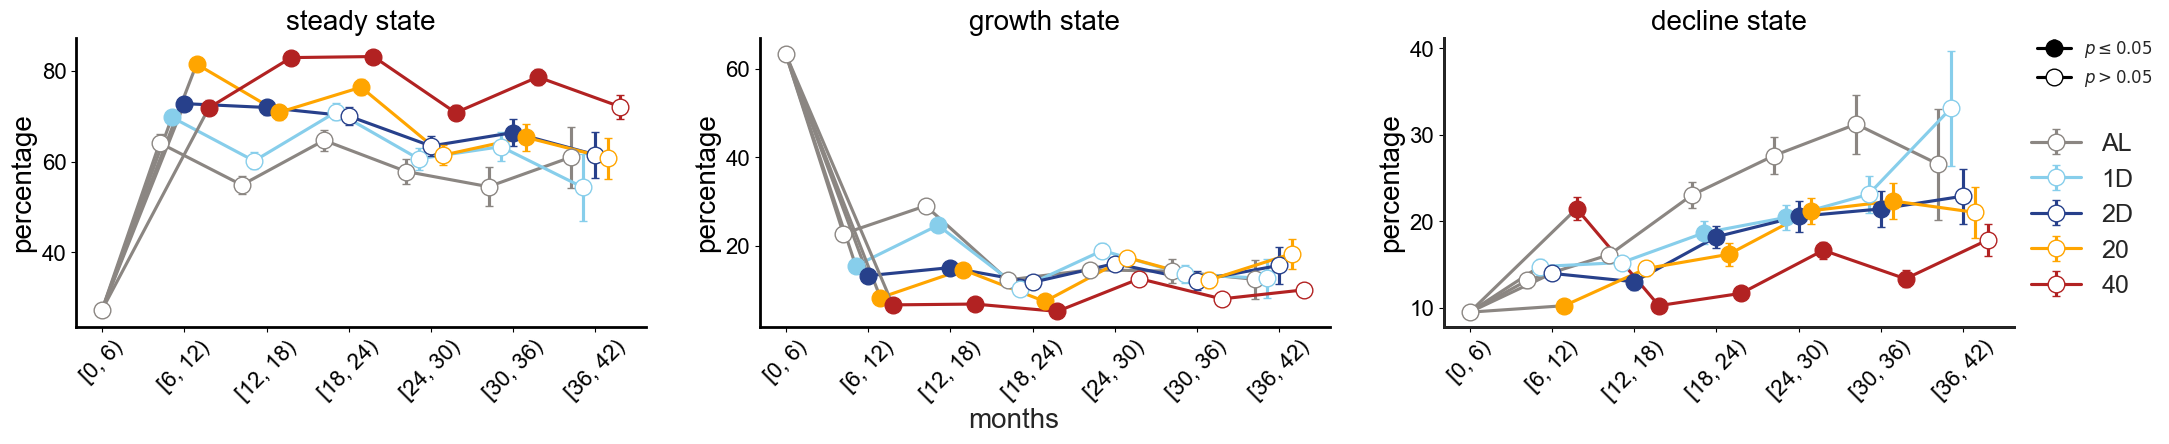

In [8]:
plot_timeinterval_ti(df_ti,
                     weighted=True,
                     phenotype='state_occupancy',
                     save=False,
                     fname='state_occupancy',
                     events=['SS', 'GS', 'DS'])

#### State transitions

##### To steady state

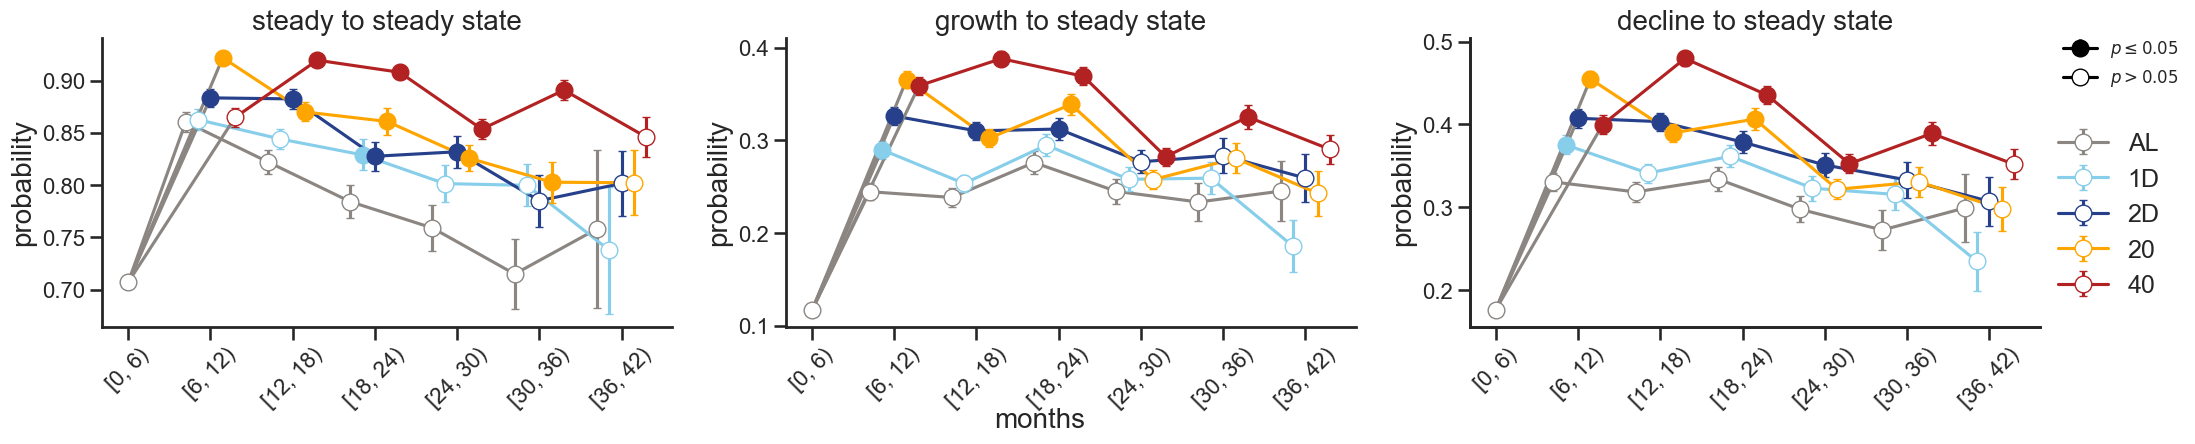

In [9]:
plot_timeinterval_ti(df_ti,
                     weighted=True,
                     phenotype='state_transitions',
                     events=['SS.SS', 'SS.GS', 'SS.DS'],
                     save=False,
                     fname='state_transitions_to_steady')

##### To decline state

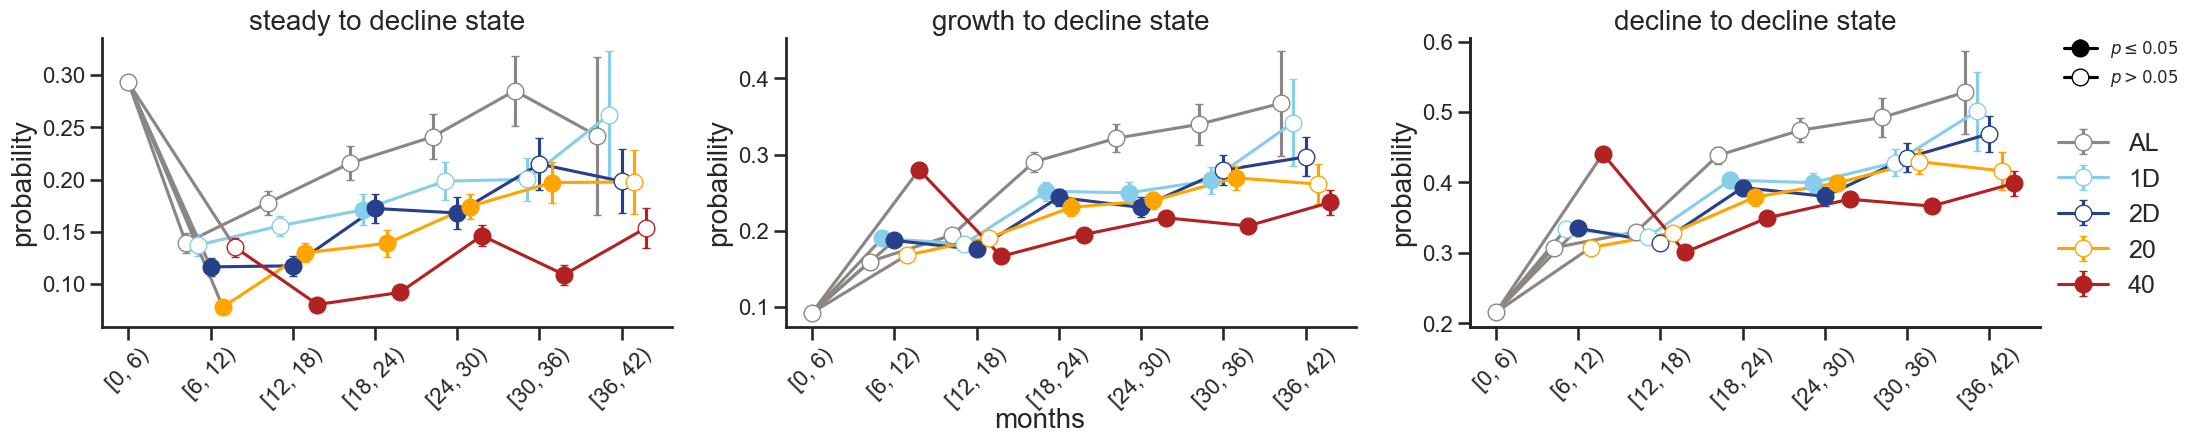

In [10]:
plot_timeinterval_ti(df_ti,
                     weighted=True,
                     phenotype='state_transitions',
                     events=['DS.SS', 'DS.GS', 'DS.DS'],
                     save=False,
                     fname='state_transitions_to_decline')

##### To growth state

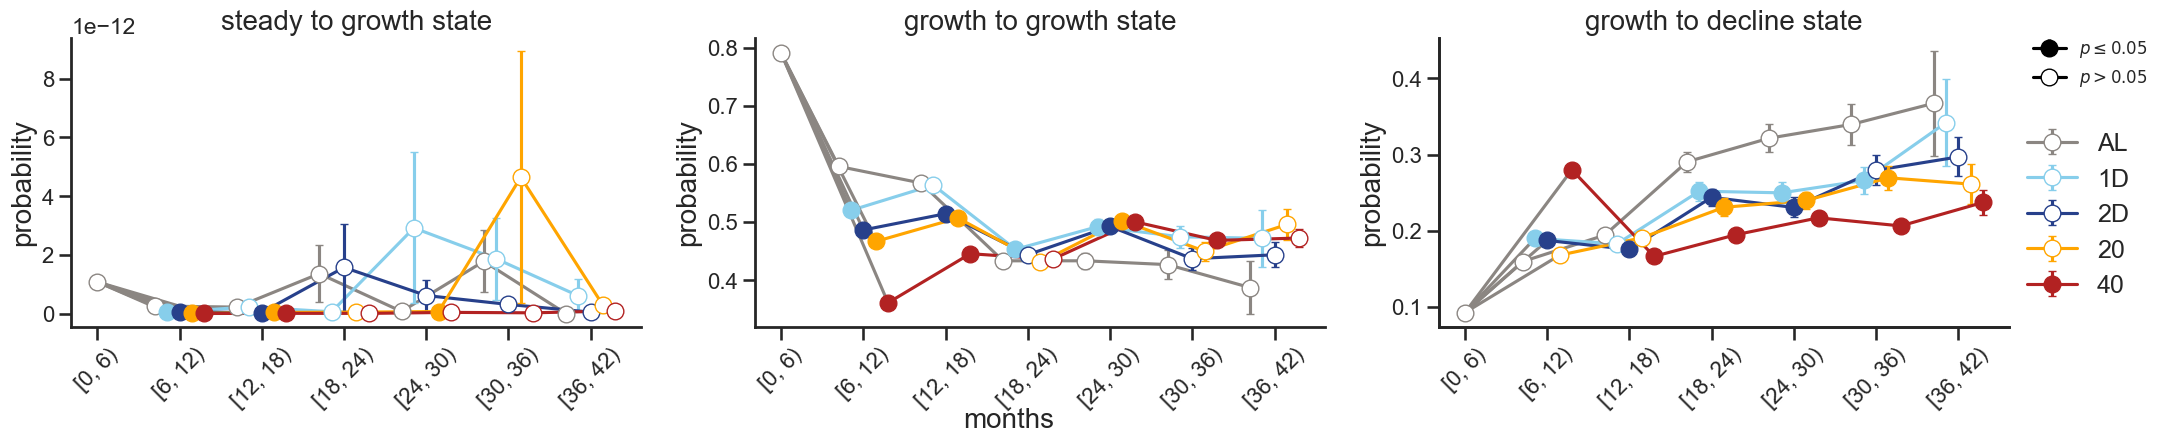

In [11]:
plot_timeinterval_ti(df_ti,
                     weighted=True,
                     phenotype='state_transitions',
                     events=['GS.SS', 'GS.GS', 'DS.GS'],
                     save=False,
                     fname='state_transitions_to_growth')

### Proportional of life lived traits

In [12]:
def plot_timeinterval_pl(df_pll,
                         phenotype='state_occupancy',
                         weighted=False,
                         events=None,
                         save=False,
                         fname=None,
                         pll_step_size=PLL_STEP_SIZE,
                         include_pre=INCLUDE_PRE):

  from matplotlib import colors
  from scipy.stats import mannwhitneyu

  # states
  state_names = ['DS', 'SS', 'GS']
  if (events is not None):
    snames = state_names
    state_names = events
  full_state_names = {
      "DS": "decline",
      "GS": "growth",
      "SS": "steady"
  }

  # diets
  diets = ["AL", "1D", "2D", "20", "40"]

  # mouse ids
  mouse_ids = df_pll.index.to_list()
  mids = {diet:[] for diet in diets}
  for diet in diets:
    for mouse in mouse_ids:
      grp = mouse.split('-')[1]
      if grp == diet:
        mids[diet].append(mouse_ids.index(mouse))

  # figure properties
  n_cols = len(state_names)
  fig, axs = plt.subplots(figsize=((25/3)*n_cols, 3.75), nrows=1, ncols=n_cols, sharey=False)
  axs = axs.ravel()
  sns.set(font_scale=1.01)
  sns.set_style("white")
  sns.set_context("talk")

  ##########################################
  # time inervals
  min_age_days = 30
  max_age_days = 1260
  interval=180

  # time inervals
  pll_time_intervals = np.arange(0, 1.01, pll_step_size)

  if phenotype in ['state_occupancy', 'state_transitions']:
    ymin, ymax = 0, 1.0
  elif phenotype == 'longest_bout':
    ymin, ymax = 0, 200

  # plot starts here
  posx = 15*np.arange(0, len(state_names))
  xshift = np.linspace(-10, 10, len(pll_time_intervals[1:]))
  ishift = np.linspace(-1/2, 1/2, len(diets))

  for s, state_name in enumerate(state_names):
    ax = axs[s]
    plt.setp(ax.spines.values(), linewidth=2)

    cnames = []
    for t, ti in enumerate(pll_time_intervals[:-1]):
      if phenotype != 'state_transitions':
        name = phenotype.replace('_', '.') + '.' + \
                "{:.1f}".format(pll_time_intervals[t]) + '.to.' + "{:.1f}".format(pll_time_intervals[t+1]) + \
                '.' + state_names[s]
      elif (phenotype == 'state_transitions') and (events is not None):
        sname = state_name.split('.')
        name = phenotype.replace('_', '.') + '.' + \
                "{:.1f}".format(pll_time_intervals[t]) + '.to.' + "{:.1f}".format(pll_time_intervals[t+1]) + \
                '.' + sname[0] + '.' + sname[1]
      cnames.append(name)

    if weighted and (phenotype in ['avg_bodyweight', 'avg_growthrate',
                                    'max_bodyweight', 'min_bodyweight',
                                    'max_growthrate', 'min_growthrate',
                                    'max_abs_growthrate', 'state_occupancy',
                                    'avg_rmse_bodyweight', 'state_transitions',
                                    'max_abs_growthrate_percent']):
      cnames = ["weighted." + c for c in cnames]

    if (not include_pre) and (phenotype in ['avg_bodyweight', 'avg_growthrate',
                                    'max_bodyweight', 'min_bodyweight',
                                    'max_growthrate', 'min_growthrate',
                                    'max_abs_growthrate', 'state_occupancy',
                                    'avg_rmse_bodyweight', 'state_transitions',
                                    'max_abs_growthrate_percent']):
      cnames = ["nopre." + c for c in cnames]

    data = df_pll[cnames].to_numpy()

    pflags = np.zeros((len(diets), data.shape[1]), dtype=bool)
    for d, diet in enumerate(diets):
      ref_data = data[mids['AL'], :]
      com_data = data[mids[diet], :]
      _, p = mannwhitneyu(ref_data, com_data, axis=0, nan_policy='omit')
      pflags[diets.index(diet), :] = p < 0.05

    for d, diet in enumerate(diets):
      if phenotype in ['state_occupancy', 'max_abs_growthrate_percent']:
        filt_data = 100*data[mids[diet], :].copy()
      else:
        filt_data = data[mids[diet], :]

      for p in range(pflags.shape[1]):
        if pflags[d, p]:
          ax.errorbar(x=posx[s]+ishift[d]+xshift[p],
                      y=np.nanmean(filt_data[:, p], axis=0),
                      yerr=np.nanstd(filt_data[:, p], axis=0)/np.sqrt(np.sum(~np.isnan(filt_data[:, p]), axis=0)),
                      marker='s',
                      ms=8,
                      color=diet_colors[d],
                      capsize=3,
                      mec=diet_colors[d])
        else:
          ax.errorbar(x=posx[s]+ishift[d]+xshift[p],
                      y=np.nanmean(filt_data[:, p], axis=0),
                      yerr=np.nanstd(filt_data[:, p], axis=0)/np.sqrt(np.sum(~np.isnan(filt_data[:, p]), axis=0)),
                      marker='s',
                      ms=8,
                      color=diet_colors[d],
                      capsize=3,
                      mec=diet_colors[d],
                      mfc='white')
      ax.plot(posx[s]+ishift[d]+xshift, np.nanmean(filt_data, axis=0),
              color=diet_colors[d])

    if phenotype == 'state_occupancy':
      ymin, ymax = 0, 100.0
      title = full_state_names[state_name]
      ylabel = "percentage"
      txt = "Time Intervals: State Occupancy"
      x_right = posx[1]-10
      y_top = 120
    elif phenotype == 'state_transitions':
      ymin, ymax = 0, 1.0
      ylabel = "probability"
      tmp = ['DS', 'SS', 'GS']
      title = "P(" + full_state_names[sname[0]] + "|" \
      + full_state_names[sname[1]] + ")"
      txt = "Time Intervals: State Transitions"
      x_right = posx[1]-10
      y_top = 1.1
    else:
      print("Phenotype not found.")
      return

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(axis='x', which='major', bottom=True, labelsize=16)
    ax.tick_params(axis='y', which='major', left=True, labelsize=16)

    xticklabels = ["{:.1f}".format(pll_time_intervals[t+1]) for t, _ in enumerate(pll_time_intervals[:-1])]
    xticks = posx[s] + xshift + ishift[2]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation= 45)

    if (s == len(state_names)-1):
      for d, diet in enumerate(diets):
        ax.errorbar(x=[],
                    y=[],
                    yerr=[],
                    label=diet,
                    ms=8,
                    marker='s',
                    color=diet_colors[d],
                    capsize=3,
                    mec=diet_colors[d],
                    mfc='white')

      handles, labels = plt.gca().get_legend_handles_labels()
      by_label = dict(zip(labels, handles))
      ax.legend(by_label.values(), by_label.keys(),
                frameon=False,
                fontsize=18,
                bbox_to_anchor=(0.75, 0.5, 0.5, 0.2))

      ax2 = ax.twinx()
      ax2.get_yaxis().set_visible(False)
      mfc_colors = ["black", "white"]
      sig_labels = [r'$ p \leq 0.05 $', r'$ p > 0.05 $']
      for m, mfc_color in enumerate(mfc_colors):
        ax2.errorbar(x=[],
                     y=[],
                     yerr=[],
                     label=sig_labels[m],
                     ms=8,
                     marker='s',
                     capsize=3,
                     color="black",
                     mec="black",
                     mfc=mfc_color)
      ax2.legend(frameon=False,
                 fontsize=12,
                 bbox_to_anchor=(0.75, 0.5, 0.52, 0.55))
      ax2.spines['right'].set_visible(False)
      ax2.spines['top'].set_visible(False)
      ax2.spines['left'].set_visible(True)
      ax2.spines['bottom'].set_visible(True)

    if (s == 0):
      ax.set_ylabel(ylabel, fontsize=20)

    if (phenotype not in ['state_transitions', 'resilience']):
      ax.set_title(full_state_names[state_name] + " state", fontsize=20)
    elif phenotype == 'state_transitions':
      sn = state_name.split('.')
      ax.set_title(full_state_names[sn[1]] + ' to ' + \
                   full_state_names[sn[0]], fontsize=20)
    elif phenotype == 'resilience':
      ax.set_title(state_name, fontsize=20)

  # fig.text(0.5, -0.30, 'proportion of life lived', ha='center', fontsize=20)
  fig.text(0.5, -0.1, 'proportion of life lived', ha='center', fontsize=20)

  # save figure
  if save and (fname is not None):
    save_figure(fdir='images',
                fname=fname)

  fig.align_labels()
  plt.show()
  return

#### State occupancy

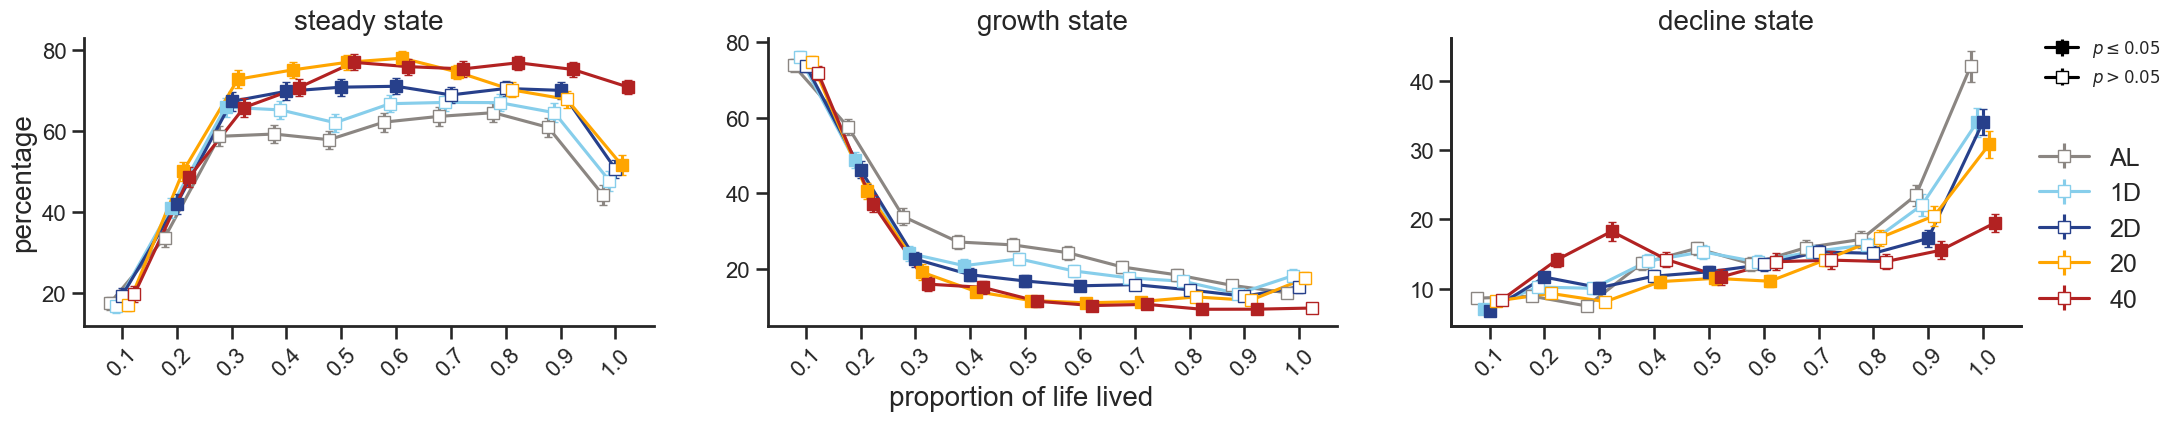

In [13]:
plot_timeinterval_pl(df_pll,
                     weighted=True,
                     phenotype='state_occupancy',
                     include_pre=True,
                     save=False,
                     events=['SS', 'GS', 'DS'],
                     fname='pll_state_occupancy')

#### State transitions

##### To steady state

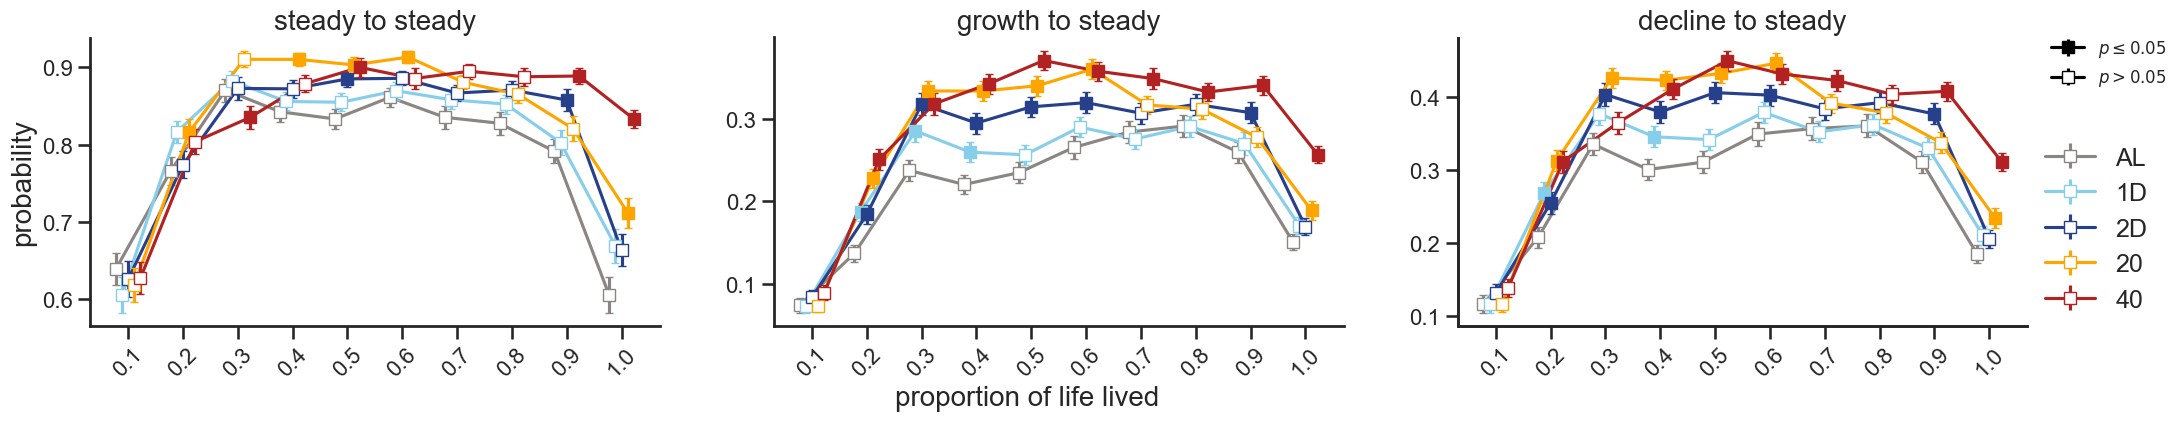

In [14]:
plot_timeinterval_pl(df_pll,
                     weighted=True,
                     phenotype='state_transitions',
                     include_pre=True,
                     save=False,
                     events=['SS.SS', 'SS.GS', 'SS.DS'],
                     fname='pll_state_transitions_to_steady')

##### To decline state

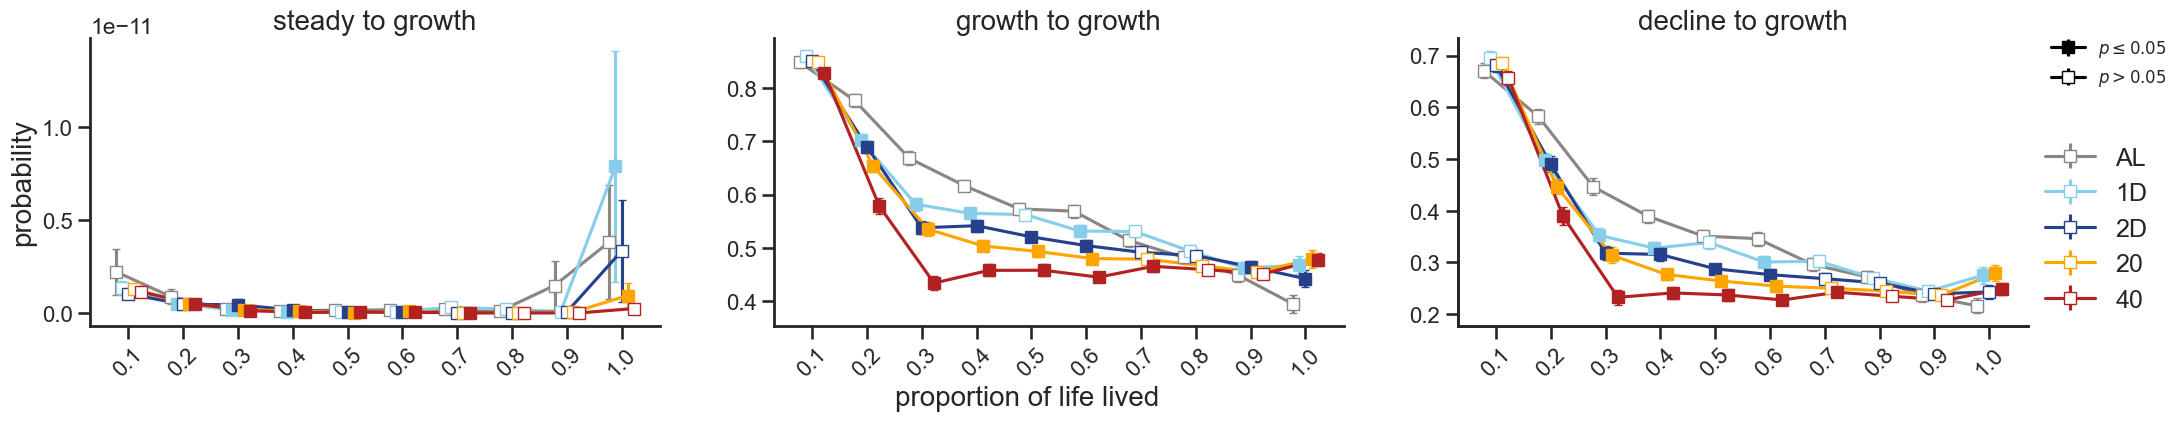

In [15]:
plot_timeinterval_pl(df_pll,
                     weighted=True,
                     phenotype='state_transitions',
                     include_pre=True,
                     save=False,
                     events=['GS.SS', 'GS.GS', 'GS.DS'],
                     fname='pll_state_transitions_to_growth')

##### To growth state

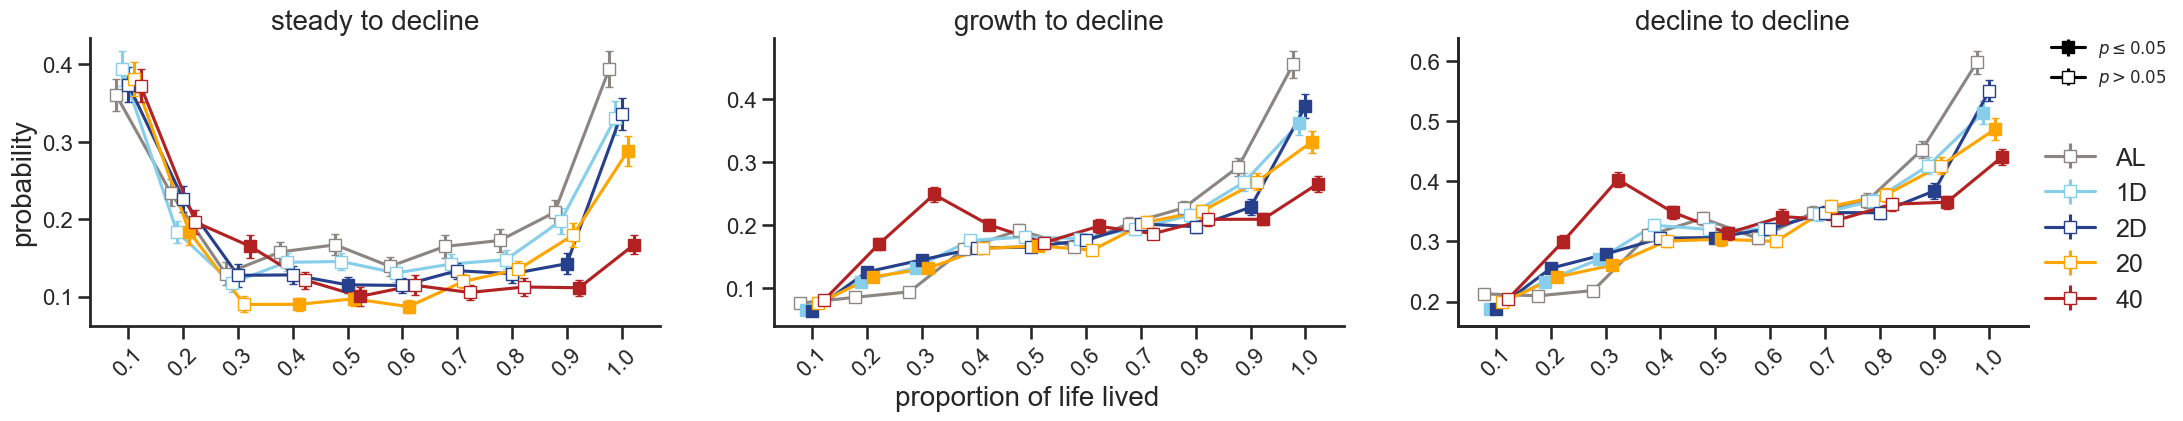

In [16]:
plot_timeinterval_pl(df_pll,
                     weighted=True,
                     phenotype='state_transitions',
                     include_pre=True,
                     save=False,
                     events=['DS.SS', 'DS.GS', 'DS.DS'],
                     fname='pll_state_transitions_to_decline')

### Pre and post-intervention traits

In [17]:
def prepost_violin_plots_pp(df_pheno,
                            weights,
                            phenotypes,
                            events=None,
                            significance=False,
                            significance_levels=None,
                            offset=None,
                            yshift_offset=None,
                            landmark=False,
                            landmark_event=None,
                            ftitle=None,
                            save=False,
                            fname=None):

  from matplotlib import colors
  from scipy.stats import mannwhitneyu

  # states
  state_names = ['DS', 'SS', 'GS']
  if events is not None:
    state_names = events
  diets = ["AL", "1D", "2D", "20", "40"]
  subtitles = {"DS": "decline",
               "SS": "steady",
               "GS": "growth"}
  
  # mouse ids
  mouse_ids = df_pheno.index.to_list()
  mids = {diet:[] for diet in diets}
  for diet in diets:
    for mouse in mouse_ids:
      grp = mouse.split('-')[1]
      if grp == diet:
        mids[diet].append(mouse_ids.index(mouse))

  # figure properties
  n_cols = len(events)
  fig, axs = plt.subplots(figsize=((12/3)*n_cols, 3.5), nrows=1, ncols=n_cols, sharey=False)
  if n_cols != 1:
    axs = axs.ravel()
  else:
    axs = [axs]
  sns.set(font_scale=1.01)
  sns.set_style("white")
  sns.set_context("talk")

  ##########################################
  # pre post
  intrevention = ['post']

  # plot starts here
  posx = 10*np.arange(0, len(state_names))
  xshift = np.linspace(-5, 5, len(diets))
  xticklabels = diets

  for s, state_name in enumerate(state_names):
    ax = axs[s]
    max_val = -np.inf

    for t, (phenotype, weighted) in enumerate(zip(phenotypes, weights)):

      for i, inter in enumerate(intrevention):
        if phenotype != 'state_transitions':
          name = inter + '.' + phenotype.replace('_', '.') + '.' + state_name

        if weighted:
          name = "weighted." + name
        data = df_pheno[name].values.astype('float')

        # pre-intervention
        if inter == 'pre':

          nan_data = data[~np.isnan(data)]
          if phenotype in ['state_occupancy', 'max_abs_growthrate_percent']:
            nan_data = 100*nan_data
          color = "grey"
          alpha = 1.0
          x = posx[s] + xshift[0]

          if np.max(nan_data) > max_val:
            max_val = np.max(nan_data)

          vpl = ax.violinplot(nan_data[nan_data < np.percentile(nan_data, 99, axis=0)],
                              positions=[x],
                              vert=True,
                              widths=1.5,
                              showmeans=False,
                              showextrema=False,
                              showmedians=False)

          color = "grey"
          alpha = 1.0

          for patch in vpl['bodies']:
            patch.set_alpha(alpha)
            patch.set_facecolor(color)
            patch.set_edgecolor(color)

          quartile1, medians, quartile3 = np.percentile(nan_data, [25, 50, 75], axis=0)
          ax.scatter(x, medians, marker='o', color='white', s=30, zorder=3)
          ax.vlines(x, quartile1, quartile3, color='k', linestyle='-', lw=5)

        # post-intervention
        else:

          ref_data = []
          pvals = []
          aucs = []

          for d, diet in enumerate(diets):
            filt_data = data[mids[diet]].copy()
            nan_data = filt_data[~np.isnan(filt_data)]
            x = posx[s] + xshift[d]

            if phenotype in ['state_occupancy', 'max_abs_growthrate_percent']:
              nan_data = 100*nan_data

            if diet == 'AL':
              ref_data = nan_data
              pval = None
            else:
              com_data = nan_data
              ustat, pval = mannwhitneyu(ref_data, com_data)
              auc = ustat / (len(ref_data) * len(com_data))
              if auc < 0.5:
                auc = 1 - auc
              pvals.append(pval)
              aucs.append(auc)

            if np.max(nan_data) > max_val:
              max_val = np.max(nan_data)

            vpl = ax.violinplot(nan_data[nan_data < np.percentile(nan_data, 99, axis=0)],
                                positions=[x],
                                vert=True,
                                widths=1.5,
                                showmeans=False,
                                showextrema=False,
                                showmedians=False)

            color=diet_colors[d]
            alpha = 1.0

            for patch in vpl['bodies']:
              patch.set_alpha(alpha)
              patch.set_facecolor(color)
              patch.set_edgecolor(color)

            quartile1, medians, quartile3 = np.percentile(nan_data, [25, 50, 75], axis=0)
            ax.scatter(x, medians, marker='o', color='white', s=30, zorder=3)
            ax.vlines(x, quartile1, quartile3, color='k', linestyle='-', lw=5)

            if significance:
              if (pval is not None) and (pval < 0.05):
                ax.hlines(significance_levels[s] + offset[s]*d,
                          posx[s] + xshift[0],
                          posx[s] + xshift[d],
                          color='k',
                          linestyle='-',
                          lw=1)
                ax.annotate(f'$auc = {auc:.2f}, p = ${pval:.1e}', (posx[s] + (xshift[0]+xshift[d])/2,
                            significance_levels[s] - yshift_offset[s] + offset[s]*d),
                            fontsize=10, ha='center')


    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

    xticks = posx[s] + xshift
    ax.set_xticks(xticks)
    ax.tick_params(axis='x', which='major', bottom=True, labelsize=16)
    ax.tick_params(axis='y', which='major', left=True, labelsize=16)
    ax.set_xticklabels(xticklabels, rotation=45, fontsize=16)
    ax.set_title(subtitles[state_name] + " state", fontsize=18, weight="regular", y=1.05)
    if s == 0:
      if 'survival' in phenotype.split('_'):
        ax.set_ylabel("fraction", fontsize=18)
      elif 'percent' in phenotype.split('_'):
        ax.set_ylabel("percent", fontsize=18)
      elif phenotype in ['max_abs_growthrate']:
        ax.set_ylabel("in grams", fontsize=18)
      else:
        ax.set_ylabel("in days", fontsize=18)

    # if landmark:
    #   _, age_stats = describe_events(df_challenge)
    #   landmarks = age_stats[landmark_event][0]
    #   landmarks_var = age_stats[landmark_event][1]
    #   mask = (landmarks > 250) & (landmarks < 900)
    #   landmarks = landmarks[mask]
    #   landmarks_var = landmarks_var[mask]
    #   for l, (lm, lm_var) in enumerate(zip(landmarks, landmarks_var)):
    #     ax.axhline(lm, linestyle='--', lw=2, color="gray")
    #     ax.axhspan(lm-lm_var, lm+lm_var, alpha=0.2, color="gray")
    #     ax.annotate(landmark_event, (posx[s]+xshift[0]+0.5, lm+20),
    #                 fontsize=10, ha='center')

    if phenotype == 'max_abs_growthrate_percent':
      ax.set_ylim([0, 40])

    ax.set_xlim([posx[s] + xshift[0]-4, posx[s] + xshift[-1]+4])

  if ftitle is not None:
    fig.suptitle(ftitle, fontsize=20, weight="bold", y=1.1, x=0.51)


  # save figure
  if save and (fname is not None):
    save_figure(fdir="images",
                fname=fname)

  return

#### Longest bout

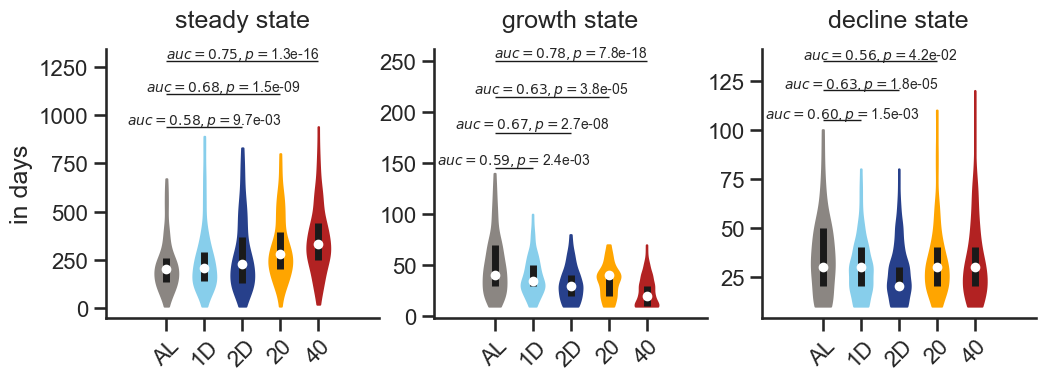

In [18]:
prepost_violin_plots_pp(df_pp,
                        weights=[False],
                        phenotypes=["longest_bout"],
                        events=["SS", "GS", "DS"],
                        significance=True,
                        significance_levels=[600, 110, 90],
                        offset=[170, 35, 15],
                        yshift_offset=[-15, -4, -1],
                        save=False,
                        fname="violin_longest_bout")

#### Longest bout normalized

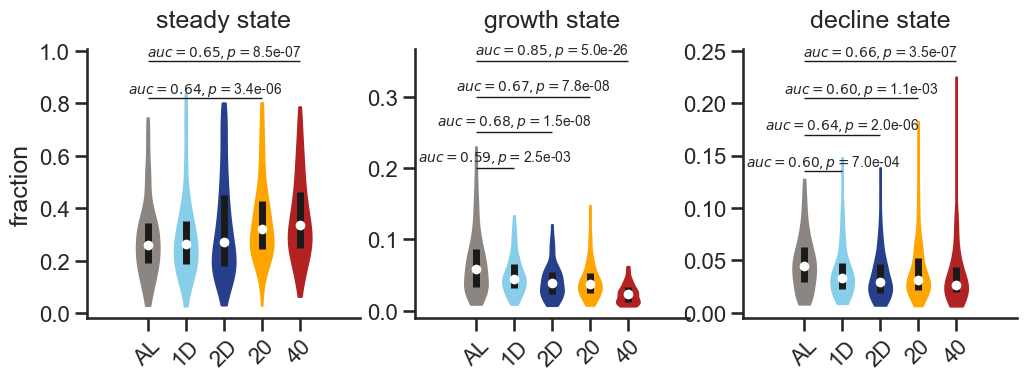

In [19]:
prepost_violin_plots_pp(df_pp,
                        weights=[False],
                        phenotypes=["longest_bout_survival"],
                        events=["SS", "GS", "DS"],
                        significance=True,
                        significance_levels=[0.4, 0.15, 0.10],
                        offset=[0.14, 0.05, 0.035],
                        yshift_offset=[-0.02, -0.01, -0.005],
                        save=False,
                        fname="violin_plot_longest_bout_survival")

#### Max absolute rate

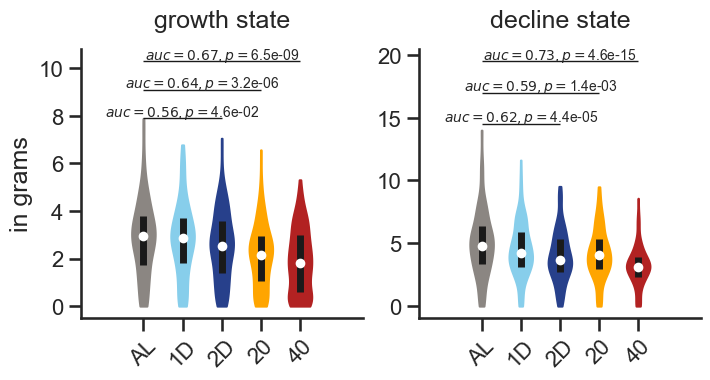

In [20]:
prepost_violin_plots_pp(df_pp,
                        weights=[True],
                        phenotypes=["max_abs_growthrate"],
                        events=["GS", "DS"],
                        significance=True,
                        significance_levels=[5.5, 9.5],
                        offset=[1.2, 2.5],
                        yshift_offset=[-0.1, -0.2],
                        save=False,
                        fname="violin_plot_max_abs_growthrate")

#### Max absolute rate normalized

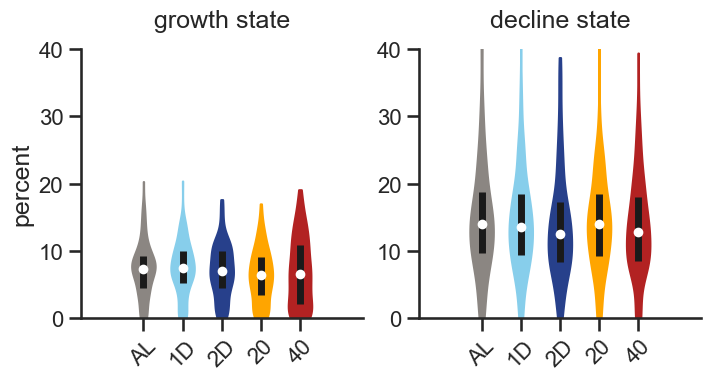

In [21]:
prepost_violin_plots_pp(df_pp,
                        weights=[True],
                        phenotypes=["max_abs_growthrate_percent"],
                        events=["GS", "DS"],
                        significance=True,
                        significance_levels=[30, 30],
                        offset=[5, 5],
                        yshift_offset=[1, 1],
                        save=False,
                        fname="violin_plot_max_abs_growthrate_percent")

#### Start time of longest bout

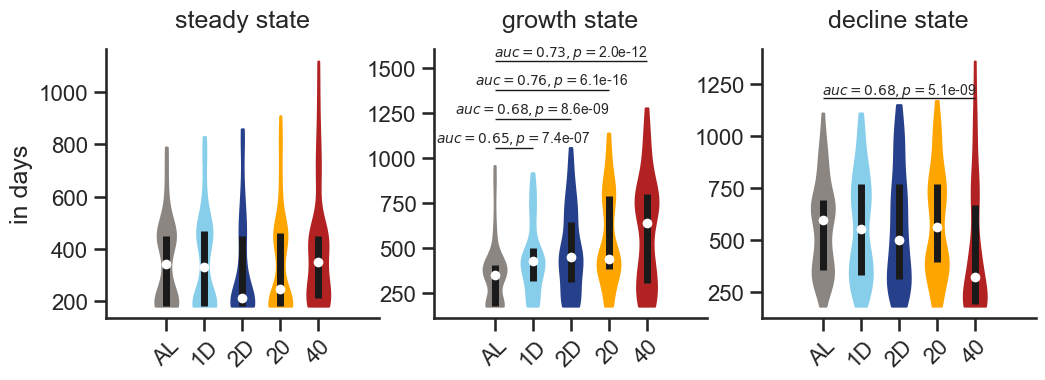

In [22]:
prepost_violin_plots_pp(df_pp,
                        weights=[False],
                        phenotypes=["start_time_longest_bout"],
                        events=["SS", "GS", "DS"],
                        significance=True,
                        significance_levels=[1100, 900, 900],
                        offset=[70, 160, 70],
                        yshift_offset=[20, -30, -20],
                        save=False,
                        fname="violin_plot_start_time_longest_bout")

#### Start time of longest bout normalized

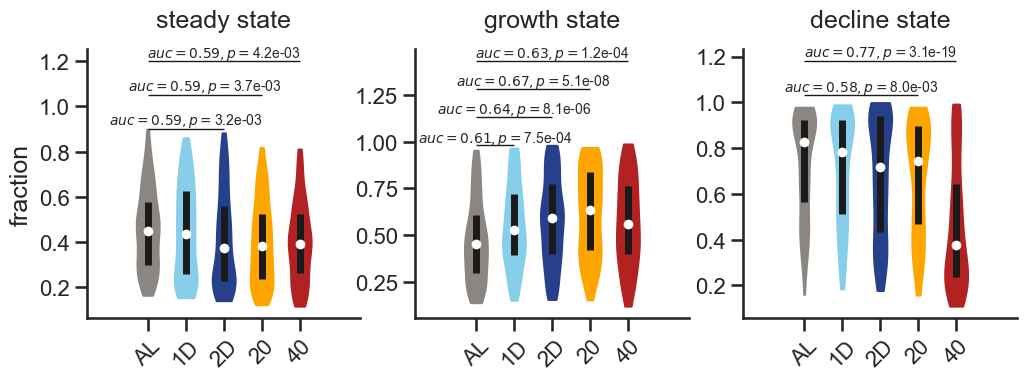

In [23]:
prepost_violin_plots_pp(df_pp,
                        weights=[False],
                        phenotypes=["start_time_longest_bout_survival"],
                        events=["SS", "GS", "DS"],
                        significance=True,
                        significance_levels=[0.6, 0.83, 0.58],
                        offset=[0.15, 0.15, 0.15],
                        yshift_offset=[-0.02, -0.02, -0.02],
                        save=False,
                        fname="violin_plot_start_time_longest_bout_survival")

#### Start time of max absolute rate

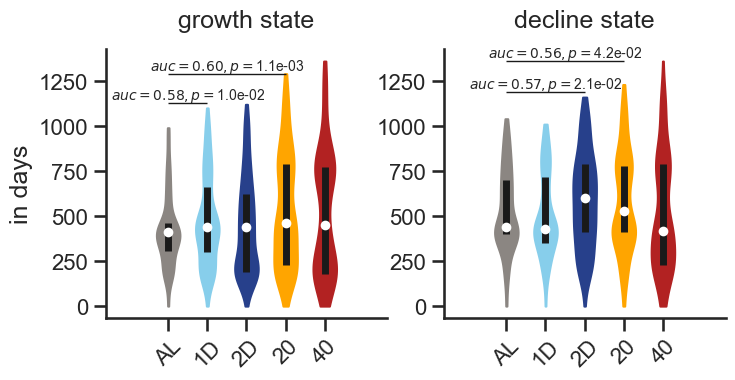

In [24]:
prepost_violin_plots_pp(df_pp,
                        weights=[False],
                        phenotypes=["start_time_max_abs_growthrate"],
                        events=["GS", "DS"],
                        significance=True,
                        significance_levels=[1050, 850],
                        offset=[80, 170],
                        yshift_offset=[-20, -20],
                        save=False,
                        fname="violin_plot_start_time_max_abs_growthrate")

#### Start time of max absolute rate normalized

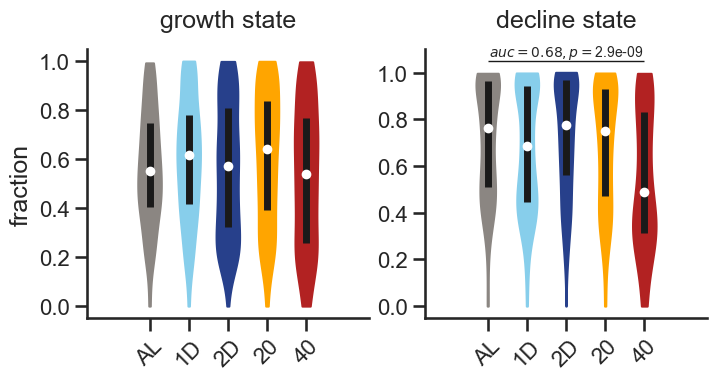

In [25]:
prepost_violin_plots_pp(df_pp,
                        weights=[False],
                        phenotypes=["start_time_max_abs_growthrate_survival"],
                        events=["GS", "DS"],
                        significance=True,
                        significance_levels=[0.5, 0.45],
                        offset=[0.15, 0.15],
                        yshift_offset=[-0.02, -0.02],
                        save=False,
                        fname="violin_plot_start_time_max_abs_growthrate_survival")

### Adaptation to stress

#### Across diets

In [26]:
def plot_radar_chart(df_rc, df_rc_err, df_rc_pflag, save=False):

  event_fullname_dict = {
                          'FA':'FACS',
                          'AC':'Acoustic Startle',
                          'HO':'Homecage Wheel',
                          'PI':'PIXI',
                          'FR':'Fraility',
                          'RO':'Rotarod',
                          'GR':'Grip',
                          'CB':'CBC',
                          'ME':'Metcage',
                          'EC':'ECG'
  }

  # The differnt dietary conditions
  DIETS = df_rc["diets"].tolist()

  # The different phenotyping events
  VARIABLES = df_rc.columns.to_list()[1:]
  XTICKLABELS = [f"{event_fullname_dict[var]}\n{var}" for var in VARIABLES]
  ROTATIONS = []
  VARIABLES_N = len(VARIABLES)

  # The angels at which the values of the numeric variables are placed
  ANGLES = [n / VARIABLES_N * 2 * np.pi for n in range(VARIABLES_N)]
  ANGLES += ANGLES[:1]

  # Padding used to customize the location of tick labels
  X_VERTICAL_TICK_PADDING = 5
  X_HORIZONTAL_TICK_PADDING = 50

  # Angel values going from 0 to 2*pi
  HANGLES = np.linspace(0, 2*np.pi)

  # Used for the equivalent of horizontal lines in cartesian coordinate plot
  # The last one is used to add a fill which acts as a background color
  H0 = np.zeros(len(HANGLES))
  H1 = np.ones(len(HANGLES)) * 0.15
  H2 = np.ones(len(HANGLES)) * 0.30

  fig = plt.figure(figsize=(14, 10))

  ax = fig.add_subplot(111, polar=True)
  ax.set_facecolor("white")

  # Rotate the "" 0 degrees on top
  # There it where the first variable, will go
  ax.set_theta_offset(np.pi / 2)
  ax.set_theta_direction(-1)
  ax.set_ylim(-0.1, 0.4)

  rshift = np.linspace(0, np.pi/18, len(DIETS))
  for idx, diet in enumerate(DIETS):
    values = df_rc.iloc[idx].drop("diets").values.tolist()
    values += values[:1]
    errs = df_rc_err.iloc[idx].drop("diets").values.tolist()
    errs += errs[:1]
    ax.errorbar(ANGLES+rshift[idx], values, yerr=errs, color=diet_colors[idx],
                linewidth=4)

    flag = df_rc_pflag.loc[diet].to_numpy()
    for j in range(df_rc_pflag.shape[1]):
      if flag[j]:
        ax.scatter(ANGLES[j] + rshift[idx],
                   values[j],
                   s=250,
                   c=np.array([diet_colors[idx]]),
                   zorder=10)
      else:
        ax.scatter(ANGLES[j] + rshift[idx],
                   values[j],
                   s=250,
                   # c=diet_colors[idx],
                   facecolors='white',
                   edgecolors=diet_colors[idx],
                   zorder=10)

  # Set values for the angular axis (x)
  ax.set_xticks(ANGLES[:-1]+rshift[2])
  ax.set_xticklabels(XTICKLABELS, size=24, weight="bold")
  labels = []
  for l, (label, angle) in enumerate(zip(ax.get_xticklabels(), ANGLES[:-1]+rshift[2])):
    angle = np.rad2deg(angle)
    x, y = label.get_position()
    lab = ax.text(x,y, label.get_text(), transform=label.get_transform(),
                  ha=label.get_ha(), va=label.get_va())
    lab.set_rotation(360 - angle)
    lab.set_fontsize(24)
    lab.set_fontweight("bold")
    labels.append(lab)
  ax.set_xticklabels([])

  # Remove lines for radial axis (y)
  ax.set_yticks([])
  ax.yaxis.grid(False)
  ax.xaxis.grid(False)

  # Remove spines
  ax.spines["start"].set_color("none")
  ax.spines["polar"].set_color("none")

  # Add custom lines for radial axis (y) at 0, 0.5 and 1.
  ax.plot(HANGLES, H0, ls=(0, (6, 6)), c="gray")
  ax.plot(HANGLES, H1, ls=(0, (6, 6)), c="gray")
  ax.plot(HANGLES, H2, ls=(0, (6, 6)), c="gray")

  # Custom guides for angular axis (x).
  # These four lines do not cross the y = 0 value, so they go from
  # the innermost circle, to the outermost circle with radius 1.
  ax.plot([0, 0], [0, 0.45], lw=2, c="gray")
  ax.plot([np.pi, np.pi], [0, 0.45], lw=2, c="gray")
  ax.plot([np.pi / 2, np.pi / 2], [0, 0.45], lw=2, c="gray")
  ax.plot([-np.pi / 2, -np.pi / 2], [0, 0.45], lw=2, c="gray")

  # Add levels
  # These labels indicate the values of the radial axis
  PAD = 0.03 / 2
  ax.text(+0.5, 0 + PAD, "0.00", size=22, color="blue", weight="bold")
  ax.text(+0.5, 0.15 + PAD, "0.15", size=22, color="blue", weight="bold")
  ax.text(+0.5, 0.30 + PAD, "0.30", size=22, color="blue", weight="bold")

  # Iterate through species names and colors.
  # These handles contain both markers and lines.
  handles = [
      Line2D(
          [], [],
          c=color,
          lw=4,
          marker="o",
          markersize=18,
          label=species,
          mfc='white'
      )
      for species, color in zip(DIETS, diet_colors)
  ]

  legend = ax.legend(
      handles=handles,
      loc=(1.1, 0),       # bottom-right
      labelspacing=0.5, # add space between labels
      frameon=False,     # don't put a frame
      fontsize=30
  )

  # add p-value legend
  ax2 = ax.figure.add_axes(ax.get_position(), projection='polar',
                           label='twin', frameon=False,
                           theta_direction=ax.get_theta_direction(),
                           theta_offset=ax.get_theta_offset())
  ax2.xaxis.set_visible(False)
  ax2.set_yticklabels([])
  ax2.spines['polar'].set_visible(False)
  ax2.axis("off")

  mfc_colors = ["black", "white"]
  sig_labels = [r'$ p \leq 0.05 $', r'$ p > 0.05 $']
  handles = [
      Line2D(
          [], [],
          c="black",
          lw=4,
          marker='o',
          markersize=18,
          label=sig_labels[m],
          mfc=mfc_color
      )
      for m, mfc_color in enumerate(mfc_colors)
  ]
  legend = ax2.legend(
      handles = handles,
      loc=(1.1, 1),
      labelspacing=0.5,
      frameon=False
  )

  # Iterate through text elements and change their properties
  for text in legend.get_texts():
    text.set_fontsize(20)       # Change default font size

  plt.tight_layout()
  save_figure(fdir='images',
              fname='radar_chart')

  plt.show()
  return

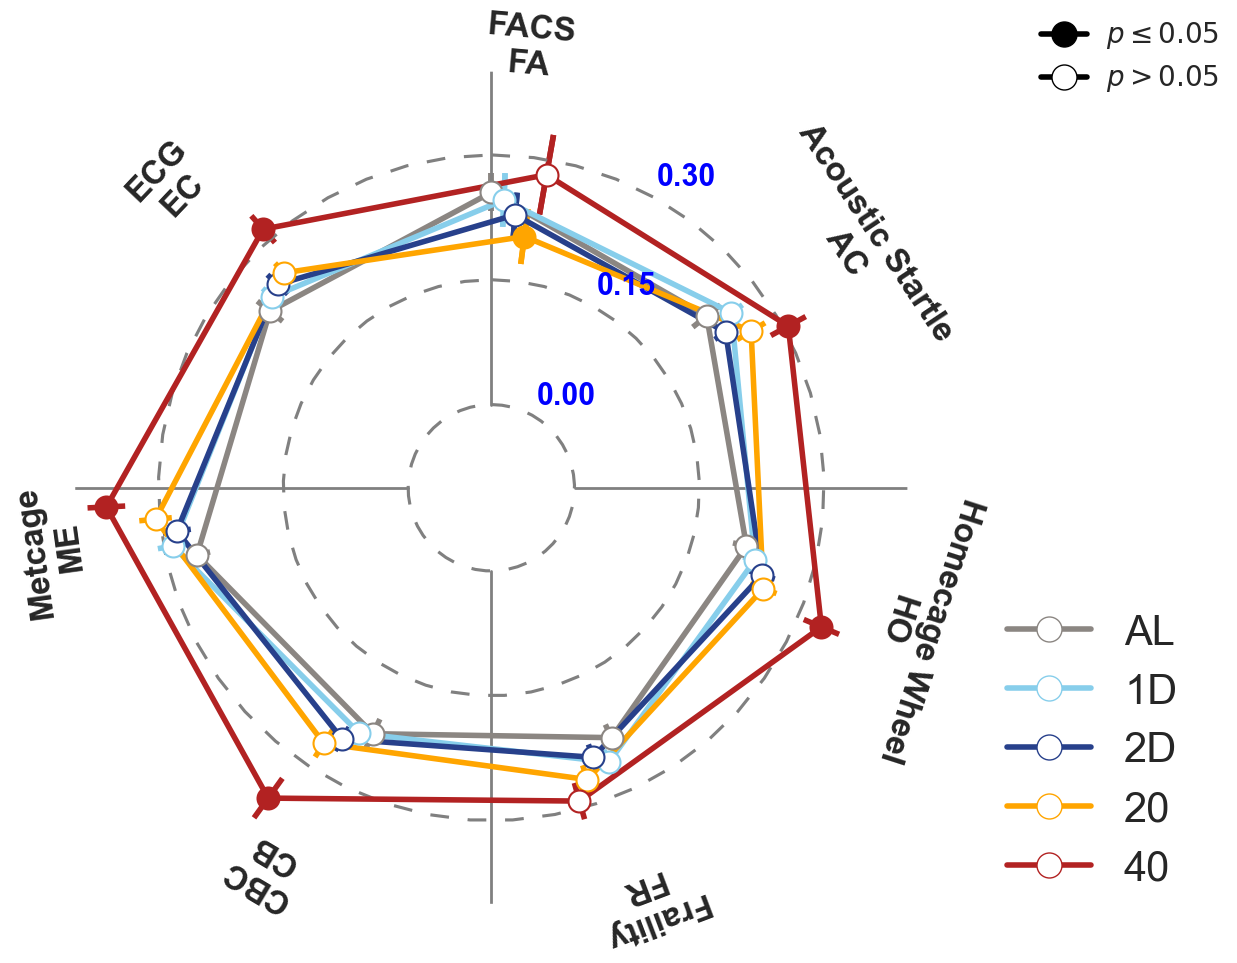

In [27]:
df_es, df_se, df_pval = create_rc_dataframe(df_bw)
plot_radar_chart(df_es, df_se, df_pval, save=False)

#### Across diets and ages

In [28]:
def plot_age_radar_chart(list_es, list_se, list_pflag, save=False):

  fig, axs = plt.subplots(figsize=(30, 6), nrows=1, ncols=5, sharey=True)
  axs = axs.ravel()
  linestyle = ['solid', 'dotted']
  alphas=[0.5, 1.0]
  markers = ['s', 'o']
  rshift = np.linspace(0, np.pi/18, len(list_es))

  for i in range(len(list_es)):

    df_rc = list_es[i]
    df_rc_err = list_se[i]
    df_rc_pflag = list_pflag[i]

    # The differnt dietary conditions
    diets = ["AL", "1D", "2D", "20", "40"]

    # The different phenotyping events
    VARIABLES = df_rc.columns.to_list()[1:]
    VARIABLES_N = len(VARIABLES)

    # The angels at which the values of the numeric variables are placed
    ANGLES = [n / VARIABLES_N * 2 * np.pi for n in range(VARIABLES_N)]
    ANGLES += ANGLES[:1]

    # Padding used to customize the location of tick labels
    X_VERTICAL_TICK_PADDING = 5
    X_HORIZONTAL_TICK_PADDING = 50

    # Angel values going from 0 to 2*pi
    HANGLES = np.linspace(0, 2*np.pi)

    # Used for the equivalent of horizontal lines in cartesian coordinate plot
    # The last one is used to add a fill which acts as a background color
    H0 = np.zeros(len(HANGLES))
    H1 = np.ones(len(HANGLES)) * 0.15
    H2 = np.ones(len(HANGLES)) * 0.30

    axs = []
    for idx, diet in enumerate(diets):
      ax = plt.subplot(1, 5, idx + 1, polar=True)
      axs.append(ax)
      ax.set_facecolor("white")

      # Rotate the "" 0 degrees on top
      # There it where the first variable, will go
      ax.set_theta_offset(np.pi / 2)
      ax.set_theta_direction(-1)
      ax.set_ylim(-0.1, 0.43)

      values = df_rc.iloc[idx].drop("diets").values.tolist()
      values += values[:1]
      errs = df_rc_err.iloc[idx].drop("diets").values.tolist()
      errs += errs[:1]

      ax.errorbar(ANGLES+rshift[i], values, yerr=errs, color=diet_colors[idx],
                  linewidth=2, marker=markers[i], alpha=alphas[i])

      flag = df_rc_pflag.loc[diet].to_numpy()
      for j in range(df_rc_pflag.shape[1]):
        if flag[j]:
          ax.scatter(ANGLES[j] + rshift[i],
                     values[j],
                     s=120,
                     marker=markers[i],
                     c=np.array([diet_colors[idx]]),
                     zorder=10,
                     alpha=alphas[i])
        else:
          ax.scatter(ANGLES[j] + rshift[i],
                     values[j],
                     s=120,
                     marker=markers[i],
                     # c=diet_colors[idx],
                     facecolors='white',
                     edgecolors=diet_colors[idx],
                     zorder=10)


      # Set values for the angular axis (x)
      ax.set_xticks(ANGLES[:-1])
      ax.set_xticklabels(VARIABLES, size=20, weight="bold")

      # Remove lines for radial axis (y)
      ax.set_yticks([])
      ax.yaxis.grid(False)
      ax.xaxis.grid(False)

      # Remove spines
      ax.spines["start"].set_color("none")
      ax.spines["polar"].set_color("none")

      # Add custom lines for radial axis (y) at 0, 0.5 and 1.
      ax.plot(HANGLES, H0, ls=(0, (6, 6)), c="gray")
      ax.plot(HANGLES, H1, ls=(0, (6, 6)), c="gray")
      ax.plot(HANGLES, H2, ls=(0, (6, 6)), c="gray")

      # Custom guides for angular axis (x).
      # These four lines do not cross the y = 0 value, so they go from
      # the innermost circle, to the outermost circle with radius 1.
      ax.plot([0, 0], [0, 0.45], lw=2, c="gray")
      ax.plot([np.pi, np.pi], [0, 0.45], lw=2, c="gray")
      ax.plot([np.pi / 2, np.pi / 2], [0, 0.45], lw=2, c="gray")
      ax.plot([-np.pi / 2, -np.pi / 2], [0, 0.45], lw=2, c="gray")

      # Add levels
      # These labels indicate the values of the radial axis
      PAD = 0.03 / 2
      ax.text(+0.5, 0 + PAD, "0.0", size=18)
      ax.text(+0.5, 0.15 + PAD, "0.15", size=18)
      ax.text(+0.5, 0.30 + PAD, "0.30", size=18)

      ax.yaxis.grid(False)
      ax.xaxis.grid(False)
      ax.set_title(diet, fontsize=24, color=diet_colors[idx])

  labels=['(6-18]', '(18-30]']
  for ax, color in zip(axs, diet_colors):
    handles = [
        Line2D(
            [], [],
            c=color,
            lw=6,
            marker=markers[j],
            markersize=12,
            label=labels[j],
            alpha=alphas[j],
            mfc='white'
        )
        for j in range(2)
    ]
    legend = ax.legend(
        handles=handles,
        loc=(0, 0),
        bbox_to_anchor=(0.9,-0.1),
        labelspacing=0.5,
        frameon=False
    )
    for text in legend.get_texts():
      text.set_fontsize(16)


    ax = axs[-1]
    ax2 = ax.figure.add_axes(ax.get_position(), projection='polar',
                            label='twin', frameon=False,
                            theta_direction=ax.get_theta_direction(),
                            theta_offset=ax.get_theta_offset())
    ax2.xaxis.set_visible(False)
    ax2.set_yticklabels([])
    ax2.spines['polar'].set_visible(False)
    ax2.axis("off")

    mfc_colors = ["black", "white"]
    sig_labels = [r'$ p \leq 0.05 $', r'$ p > 0.05 $']
    handles = [
        Line2D(
            [], [],
            c="black",
            lw=4,
            marker='o',
            markersize=12,
            label=sig_labels[m],
            mfc=mfc_color
        )
        for m, mfc_color in enumerate(mfc_colors)
    ]
    legend = ax2.legend(
        handles = handles,
        loc=(0.95, 1),
        labelspacing=0.5,
        frameon=False
    )

  plt.subplots_adjust(wspace=0.25)
  if save:
    save_figure(fdir='images',
                fname='resilience_with_age')

  plt.show()
  return

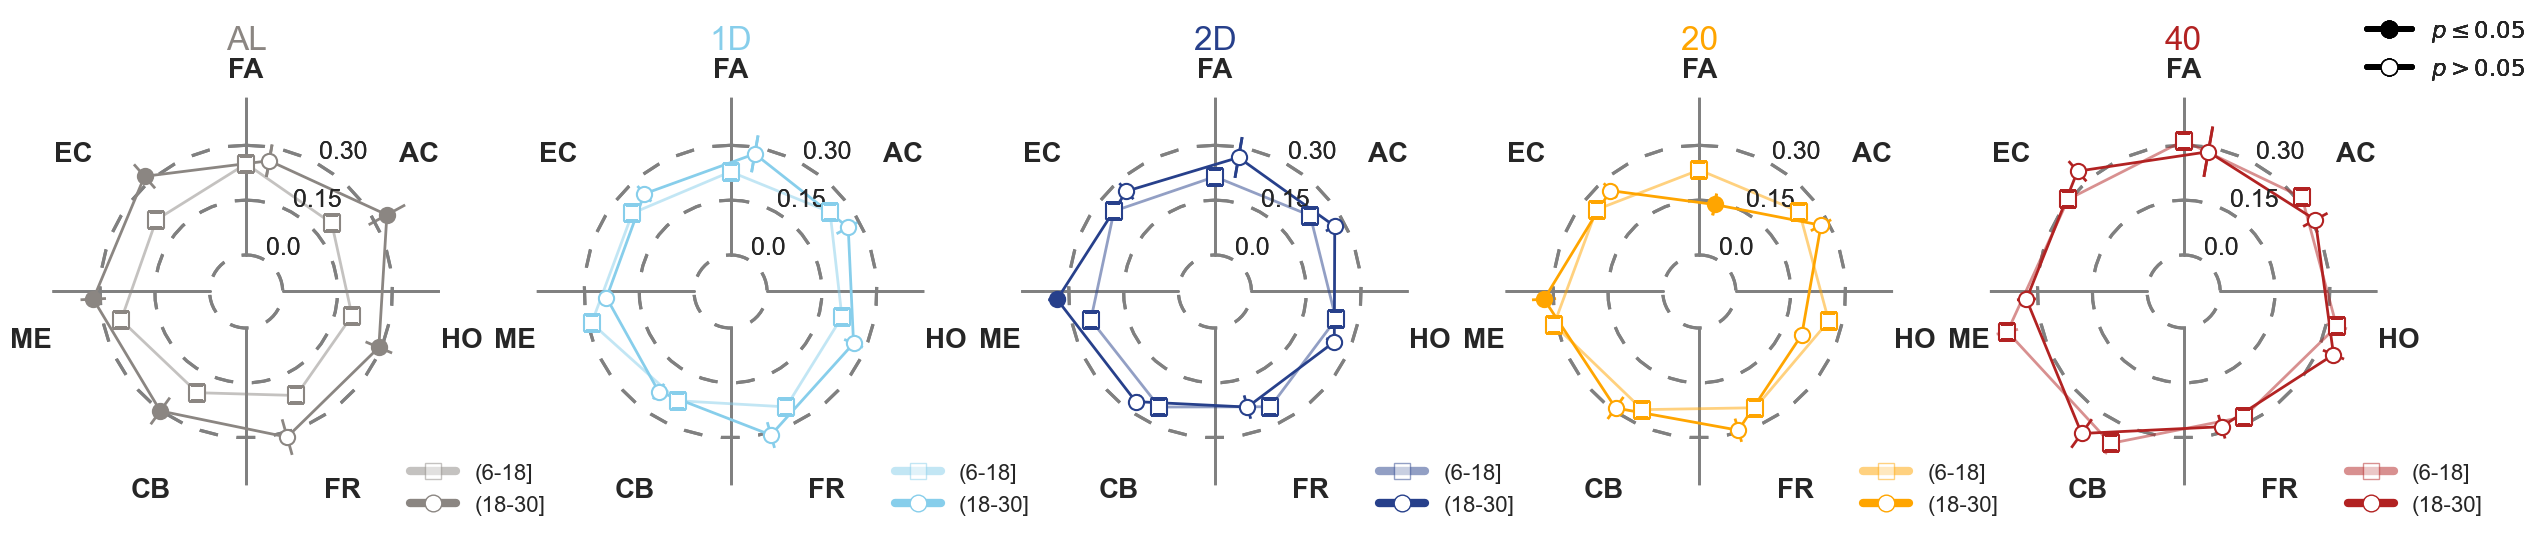

In [29]:
age_in_days_range = [[9*30, 19*30], [19*30, 29*30]]
list_es, list_se, list_pval = create_age_rc_dataframe(df_bw, age_in_days_range)
plot_age_radar_chart(list_es, list_se, list_pval)